# Ejemplo CycleGan para limpieza de texto

Adaptado del ejemplo CycleGan de tensorflow

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb


In [1]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-icya1zhe
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-icya1zhe
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ca5a4fbbc7df097ec3110fe4c1f51e77897819f8_-py3-none-any.whl size=299558 sha256=5a7b05cc1a1c0ef3d30913b19aad95175844a15512f313f2323a6bf31b7353cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-l7utzbo_/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
path_GTA = "/content/drive/MyDrive/GTA/"
path_Reales = "/content/drive/MyDrive/Reales/"
# path_GTA = "/content/drive/MyDrive/Simulaciones/"
# path_CARLA = "/content/drive/MyDrive/Simulaciones/"

In [6]:
images_GTA = os.listdir(path_GTA)
images_Reales = os.listdir(path_Reales)
# images_Simulaciones = os.listdir(path_Simulaciones)

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/datasets#cycle_gan). 

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [7]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

## Import and reuse the Pix2Pix models

In [8]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [9]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   3072        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131328      ['sequential[0][0]']             
                                128)                                                          

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer).

In [10]:
LAMBDA = 10

In [11]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [13]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [14]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [15]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [16]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [17]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

Note: This example model is trained for fewer epochs (40) than the paper (200) to keep training time reasonable for this tutorial. Predictions may be less accurate. 

In [18]:
EPOCHS = 40

In [19]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [20]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [21]:
import imageio

im = imageio.imread(path_GTA + images_GTA[0])
im2 = imageio.imread(path_Reales + images_Reales[0])

In [22]:
print(im.shape)
print(im2.shape)

(1052, 1914, 3)
(1024, 2048, 3)


In [23]:
import imageio
import numpy as np

ind = [2,3,5,6,8,9]

X = np.zeros((len(ind),im.shape[0],im.shape[1],3))
Y = np.zeros((len(ind),im2.shape[0],im2.shape[1],3))


for n in range(0,len(ind)):
    X[n,:,:,:] = imageio.imread(path_GTA + images_GTA[n])
    Y[n,:,:,:] = imageio.imread(path_Reales + images_Reales[n])

XX = tf.image.resize(X,(256,256))
YY = tf.image.resize(Y,(256,256))

In [24]:
XX = (XX-128)/128
YY = (YY-128)/128

In [25]:
print(XX.shape)
print(YY.shape)

(6, 256, 256, 3)
(6, 256, 256, 3)


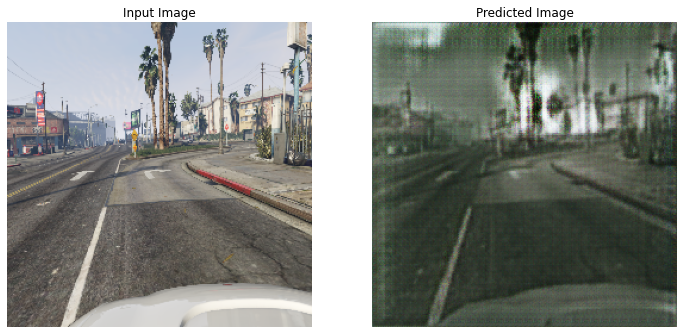

Saving checkpoint for epoch 40 at ./checkpoints/train/ckpt-24
Time taken for epoch 40 is 19.56767749786377 sec



In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    #for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    for i in range(0,X.shape[3]):
        image_x = XX[i:i+1,:,:,:]
        image_y = YY[i:i+1,:,:,:]

        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

        clear_output(wait=True)
        # Using a consistent image (sample_horse) so that the progress of the model
        # is clearly visible.
        #generate_images(generator_g, sample_horse)
        generate_images(generator_g, XX[0:1,:,:,:])

        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                                ckpt_save_path))

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))

## Generate using test dataset

In [ ]:
im = imageio.imread(path_GTA + images_GTA[1000])

In [ ]:
# im_test = np.zeros((1,im.shape[0],im.shape[1],3))

im_test = np.reshape(im,(1,im.shape[0],im.shape[1],3))

# im_test[0,:,:,0] = aa
# im_test[0,:,:,1] = aa
# im_test[0,:,:,2] = aa

In [ ]:
im_test = tf.image.resize(im_test,(256,256))

im_test = (im_test-128)/128 

In [ ]:
im_test[0:1,:,:,:].shape

TensorShape([1, 256, 256, 3])

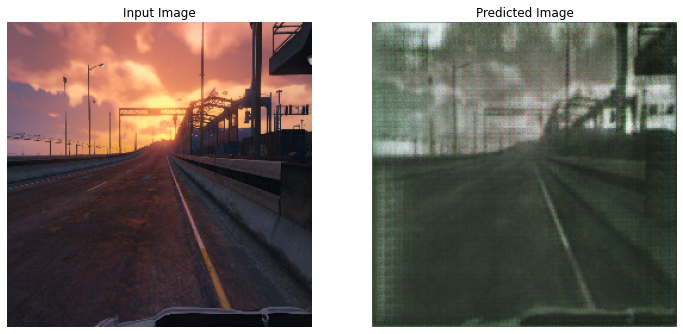

In [ ]:
# Run the trained model on the test dataset
generate_images(generator_g, im_test[0:1,:,:,:])

## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/datasets#cycle_gan). 

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.